# Tarea 6

In [82]:
import pandas as pd
import numpy as np

from dotenv import load_dotenv
import os

In [83]:
load_dotenv()
smm2_df = pd.read_csv(os.getenv("DATASET_STORE_FILE"))
columns_to_drop = ['data_id', 'name', 'description', 'gamestyle', 'theme', 'tag1', 'tag2', 'clear_condition', 'clear_condition_magnitude', 'weekly_likes', 'weekly_plays', 'uploader_pid', 'first_completer_pid', 'record_holder_pid']
smm2_df_clean = smm2_df.drop(columns_to_drop, axis=1)
smm2_df_clean['unique_clear_rate'] = np.minimum(smm2_df_clean['clears'] / smm2_df_clean['unique_players_and_versus'], 1.0)
smm2_df_clean.head(5)

,uploaded,created,difficulty,game_version,world_record,upload_time,upload_attempts,num_comments,timer,autoscroll_speed,clears,attempts,clear_rate,plays,versus_matches,coop_matches,likes,boos,unique_players_and_versus,unique_clear_rate
0,1621061069,1621092960,2,5,15283,15266,1,0,20,0,23,396,5.808081,45,0,0,3,2,38,0.605263
1,1621077412,1621080840,1,5,47217,62592,1,0,500,0,16,59,27.118644,26,0,0,1,1,24,0.666667
2,1621051239,1621033080,1,5,53933,57333,1,0,200,0,1,12,8.333333,4,0,0,0,0,4,0.250000
3,1621064079,1620710520,1,5,223387,198789,1,1,500,0,6,59,10.169492,22,0,0,1,0,21,0.285714
4,1621059182,1620229080,0,5,20533,32690,3,2,300,0,84,160,52.500000,95,2,0,13,4,86,0.976744


## Selección de características

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector

La calificación f1 esta hecha para la clasificación ya que esta utiliza la cantidad de verdaderos positivos, falsos positivos y falsos negativos para calcular su calificación la cual se define mediante:
$$
F1 = \frac{2 \times TP}{2 \times TP + FP + FN}
$$
Donde $TP$ es la cantidad de verdaderos positivos, $FP$ la de falsos positivos, y $FN$ la de falsos negativos.

In [85]:
scaler = StandardScaler()

smm2_x_df = smm2_df_clean.drop(columns=['difficulty'], axis=1)
smm2_y_df = smm2_df_clean['difficulty']

X = scaler.fit_transform(smm2_x_df)
y = smm2_y_df.values

In [86]:
selector = SelectPercentile(f_classif, percentile=50)
X_selected = selector.fit_transform(X, y)
columns_selected = smm2_x_df.columns[selector.get_support()]
columns_selected

Index(['world_record', 'upload_time', 'upload_attempts', 'timer', 'clears',
       'attempts', 'clear_rate', 'boos', 'unique_clear_rate'],
      dtype='object')

In [87]:
estimator = LogisticRegression(max_iter=1_000)
sfs = SequentialFeatureSelector(estimator=estimator, k_features=(1, len(X_selected[0])), forward=True, scoring='f1_weighted', cv=5)
sfs = sfs.fit(pd.DataFrame(X_selected, columns=columns_selected), y)

sfs_result = pd.DataFrame(sfs.get_metric_dict()).T
sfs_result = sfs_result.sort_values('avg_score', ascending = False)
sfs_result

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
3,"(2, 3, 6)","[0.8157102401508365, 0.823086222282004, 0.8296...",0.821842,"(upload_attempts, timer, clear_rate)",0.007629,0.005936,0.002968
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)","[0.8138823586243548, 0.8273921204521124, 0.826...",0.821597,"(world_record, upload_time, upload_attempts, t...",0.007666,0.005964,0.002982
8,"(0, 1, 2, 3, 4, 5, 6, 7)","[0.8103490964844119, 0.8281278530951051, 0.830...",0.821495,"(world_record, upload_time, upload_attempts, t...",0.010715,0.008336,0.004168
4,"(2, 3, 6, 7)","[0.8151708782878556, 0.8252632315637707, 0.829...",0.821313,"(upload_attempts, timer, clear_rate, boos)",0.008429,0.006558,0.003279
5,"(0, 2, 3, 6, 7)","[0.8116270783336919, 0.8255086153682493, 0.830...",0.821139,"(world_record, upload_attempts, timer, clear_r...",0.008791,0.00684,0.00342
6,"(0, 1, 2, 3, 6, 7)","[0.808028369530122, 0.8297294053651098, 0.8296...",0.820701,"(world_record, upload_time, upload_attempts, t...",0.011648,0.009063,0.004531
7,"(0, 1, 2, 3, 4, 6, 7)","[0.8065202460213708, 0.8296496138916735, 0.829...",0.820509,"(world_record, upload_time, upload_attempts, t...",0.012209,0.009499,0.00475
2,"(2, 6)","[0.8115852098241817, 0.8214414627431167, 0.828...",0.818724,"(upload_attempts, clear_rate)",0.009081,0.007065,0.003533
1,"(6,)","[0.8058590066944497, 0.8125580272934431, 0.818...",0.809867,"(clear_rate,)",0.008789,0.006838,0.003419


## Clasificación

In [103]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Los árboles de decisión clasifican datos dividiendo el espacio de atributos \(X\) en regiones \(R_m\).  
Cada región se asigna a una clase según la proporción de observaciones:

$$
p_{mk} = \frac{1}{N_m} \sum_{x_i \in R_m} I(y_i = k)
$$

La predicción elige la clase más frecuente en la región:

$$
k(m) = \arg\max_k p_{mk}
$$

Para evaluar la calidad de las divisiones se usan medidas de impureza como el índice Gini:

$$
\text{Gini}(R_m) = \sum_{k=1}^K p_{mk}(1 - p_{mk})
$$

In [89]:
smm2_df_train = smm2_df_clean.sample(frac=0.7)
smm2_df_test = smm2_df_clean.drop(smm2_df_train.index)

X_train = smm2_df_train[['upload_attempts', 'clear_rate']].values
y_train = smm2_df_train['difficulty'].values

X_test = smm2_df_test[['upload_attempts', 'clear_rate']].values
y_test = smm2_df_test['difficulty'].values

In [90]:
depth_iter = range(2, 25)

depth_scores = {}
depth_clfs = {}
for depth in depth_iter:
    dt_classifier = DecisionTreeClassifier(max_depth=depth)

    clf = make_pipeline(StandardScaler(), dt_classifier)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    
    depth_scores[depth] = score
    depth_clfs[depth] = clf
    
max_depth = max(depth_scores, key=depth_scores.get)
max_clf = depth_clfs[max_depth]
print(f'Best max_depth={max_depth} with score={depth_scores[max_depth]}')

Best max_depth=7 with score=0.8256666666666667


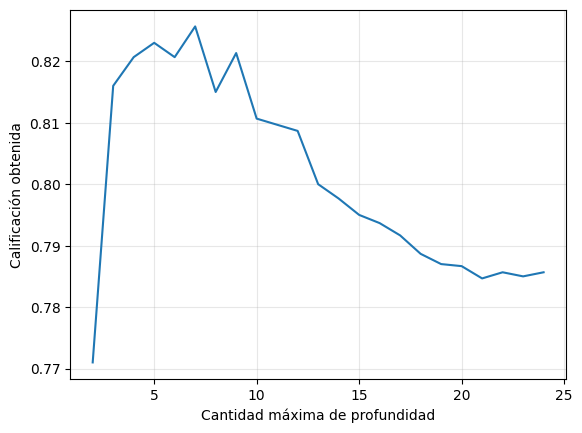

In [100]:
plt.plot(depth_scores.keys(), depth_scores.values())
plt.xlabel('Cantidad máxima de profundidad')
plt.ylabel('Calificación obtenida')
plt.grid(True, alpha=0.3)
plt.show()

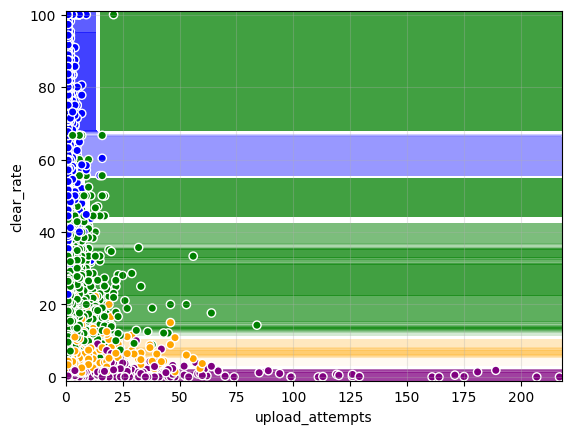

In [102]:
DecisionBoundaryDisplay.from_estimator(max_clf, np.concatenate((X_train, X_test), axis=0), multiclass_colors=['blue', 'green', 'orange', 'purple'], alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(['blue', 'green', 'orange', 'purple']), edgecolors='w')
plt.xlabel('upload_attempts')
plt.ylabel('clear_rate')
plt.grid(True, alpha=0.3)
plt.show()

### Matriz discriminante

In [109]:
import seaborn as sns

In [110]:
smm2_dt_test_results = np.zeros([4, 4])
smm2_dt_predictions = max_clf.predict(X_test)
for pred, real in zip(smm2_dt_predictions, y_test):
    smm2_dt_test_results[real][pred] +=1
smm2_dt_test_results

array([[9.410e+02, 1.380e+02, 0.000e+00, 0.000e+00],
       [1.680e+02, 1.142e+03, 3.700e+01, 0.000e+00],
       [1.000e+00, 1.330e+02, 2.140e+02, 2.600e+01],
       [0.000e+00, 1.000e+00, 1.900e+01, 1.800e+02]])

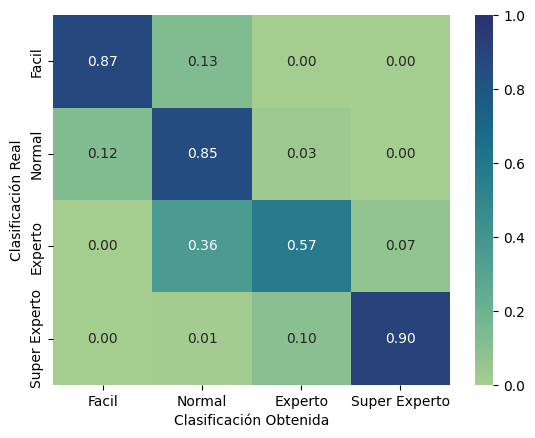

In [111]:
smm2_dt_test_results_df = pd.DataFrame(smm2_dt_test_results, columns=['Facil', 'Normal', 'Experto', 'Super Experto'], index=['Facil', 'Normal', 'Experto', 'Super Experto'])
smm2_dt_test_results_norm = smm2_dt_test_results_df.div(smm2_dt_test_results_df.sum(axis=1), axis=0)

sns.heatmap(smm2_dt_test_results_norm, cmap="crest", annot=True, fmt=".2f", vmin=0.0, vmax=1.0)
plt.xlabel('Clasificación Obtenida')
plt.ylabel('Clasificación Real')
plt.show()